In [147]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
import seaborn as sns
import os
import pandas as pd
import math

In [3]:
from ultralytics import YOLO

In [ ]:
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"
FileName = "2024_07_09_11_30_174.jpg"
raw_img = cv.imread(Directory + "/" + FileName)
img = cv.cvtColor(raw_img, cv.COLOR_BGR2GRAY)
img = raw_img

In [2]:
model = YOLO('best.pt', task='segment')

In [ ]:
model = YOLO('best.pt')
results = model(img, conf=0.3, save=True, show_labels=False, retina_masks=True)

**Pre and Post processing time**
- reduced from 5 seconds to ms by resizing the image before applying to the model

# Video Inferencing

In [ ]:
from ultralytics.utils.plotting import Annotator, colors

In [49]:
def im_show(img):
    cv.imshow('1', img)
    cv.waitKey()

In [106]:
# Camera Perspective View to Top View Transformation
def camera_angle2top_view():
    points = pd.read_csv('Points.csv')
    ref_pts = np.array([points.iloc[i,:2] for i in range(1, len(points))], dtype = 'uint16')
    dst_pts = np.array([points.iloc[i,2:] for i in range(1, len(points))], dtype = 'uint16')
    h, status = cv.findHomography(ref_pts, dst_pts)
    #print(ref_pts, dst_pts)
    return h

In [83]:
def InferenceImage(frame, model, width, height, conf, iou):
    img_resize = cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)
    results = model(img_resize, conf=conf, iou=iou)
    return results

In [7]:
count_frame = 0
fps = 1
alpha = 0.8
Directory = r"F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1"

width = height = 640
Files = os.listdir(Directory)
Files = ['2024_07_09_11_30_114.jpg']#, '2024_07_09_11_30_115.jpg', '2024_07_09_11_30_116.jpg', '2024_07_09_11_30_117.jpg', '2024_07_09_11_30_118.jpg']
im_ref = cv.imread('ReferenceImage.jpg')
im_layout = cv.imread('SquareLayout.jpg')  

In [5]:
model = YOLO('best.pt')

In [8]:
res = InferenceImage(cv.imread(Directory + "/" + Files[0]), model, width, height)


0: 640x640 3 Fire-Smoke-Sodium-Trays, 5831.3ms
Speed: 75.1ms preprocess, 5831.3ms inference, 385.4ms postprocess per image at shape (1, 3, 640, 640)


In [9]:
mask_img = np.any(np.array(res[0].masks[:].data), axis=0)
mask_img

array([[False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       ...,
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False],
       [False, False, False, ..., False, False, False]])

(232, 247) (255, 287)
(117, 262) (193, 376)
(287, 180) (314, 222)


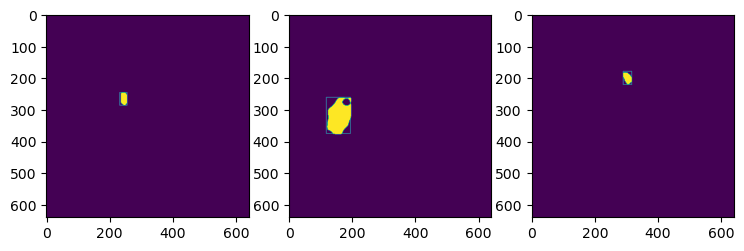

In [72]:
plt.figure(figsize=(12,6))
for i in range(len(res[0].masks)):
    plt.subplot(1,4,i+1)
    mask_img = np.any(np.array(res[0].masks[i].data), axis=0)
    plt.imshow(mask_img)
    plt.imshow(cv.rectangle(mask_img*255,tuple(np.array(res[0].boxes[i].data[0][:2], dtype='int')),tuple(np.array(res[0].boxes[i].data[0][2:4], dtype='int')),255,1))
    print(tuple(np.array(res[0].boxes[i].data[0][:2], dtype='int')),tuple(np.array(res[0].boxes[i].data[0][2:4], dtype='int')))

In [85]:
hierarchies[0]

array([[ 1, -1, -1, -1],
       [ 2,  0, -1, -1],
       [ 3,  1, -1, -1],
       [-1,  2, -1, -1]], dtype=int32)

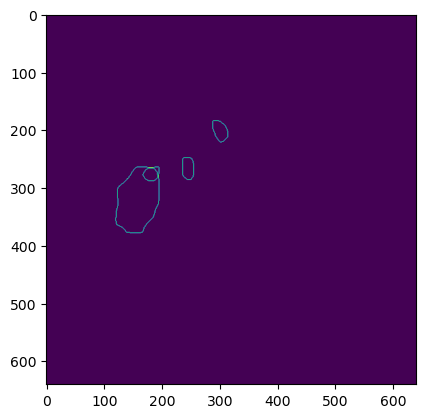

In [86]:
blank = np.zeros(mask_img.shape[:2], dtype='uint8')
plt.imshow(cv.drawContours(blank, contours, -1, (255, 0, 0), 1))

180 277
158 320
245 266
300 201


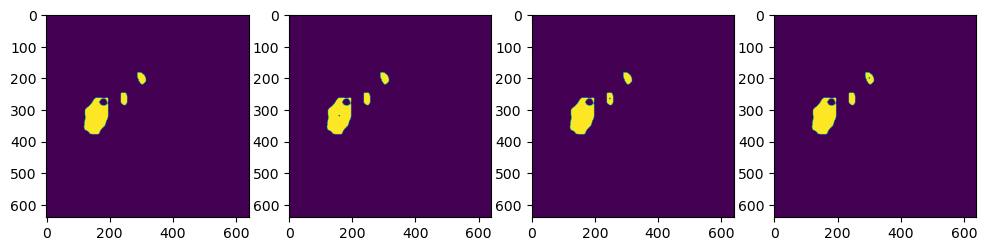

In [34]:
plt.figure(figsize=(12,6))
contours, hierarchies = cv.findContours(mask_img.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
cnt=1
for i in contours:
    M = cv.moments(i)
    if M['m00'] != 0:
        cx = int(M['m10']/M['m00'])
        cy = int(M['m01']/M['m00'])
        print(cx, cy)
        plt.subplot(1,4,cnt)
        cnt += 1
        plt.imshow(cv.circle(mask_img.astype(np.uint8), (cx, cy), 2, (0, 0, 255), -1))
#         cv.drawContours(image, [i], -1, (0, 255, 0), 2)
#         cv.circle(image, (cx, cy), 7, (0, 0, 255), -1)
#         cv.putText(image, "center", (cx - 20, cy - 20),
#         cv.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 2)
#         print(f"x: {cx} y: {cy}")

In [143]:
out = cv.VideoWriter("inst_segment.avi", cv.VideoWriter_fourcc(*"MJPG"), fps, (3*width, height))
#out2 = cv.VideoWriter("inst_seg_layout.avi", cv.VideoWriter_fourcc(*"MJPG"), fps, (im_layout.shape[1], im_layout.shape[0]))
video = cv.VideoCapture(r"F:\Work\SOCAAutomation\Dataset\NA_DISOPSAL_SOCA_2024\09072024\AXIS 213 - 10.1.5.173 2024-07-09_11_30_00_000.asf")
dur = [[3,0], [3,45]] #[mins,secs]
startFrame = (dur[0][0] * 60 + dur[0][1] ) * 15
endFrame = (dur[1][0] * 60 + dur[1][1] ) * 15

In [144]:
count_frame = 0
h = camera_angle2top_view()
while True:
    ret, frame = video.read()
    if ret:
        count_frame += 1
        if count_frame > startFrame and count_frame < endFrame:
            #frame = cv.imread(Directory + "/" + Files[count_frame])
            img_resize = cv.resize(frame, (width, height), interpolation = cv.INTER_LINEAR)
            results = model(img_resize, conf=0.5)
            if results[0].masks is not None:
                mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
                mask_img_3 = np.stack([np.zeros(mask_img.shape), mask_img, np.zeros(mask_img.shape)], axis=2)
                temp_image = cv.addWeighted(img_resize, alpha , (mask_img_3 * 255).astype('uint8'), 1-alpha, 0)        
                im_out = cv.warpPerspective(mask_img_3, h, (im_layout.shape[1],im_layout.shape[0]))
                im_layout_inv = 255 - im_layout
                layout_mask = cv.add(im_layout_inv, (im_out * 255).astype('uint8'))
                #layout_mask = cv.addWeighted(im_layout, 0.3 , (im_out * 255).astype('uint8'), 1-0.3, 0)
            else:
                temp_image = img_resize
                layout_mask = 255 - im_layout
                
            out.write(np.hstack([img_resize, temp_image, layout_mask]))
            #out2.write(layout_mask)        
    else:
        break
out.release()
#out2.release()
video.release()


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3615.2ms
Speed: 6.0ms preprocess, 3615.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4861.4ms
Speed: 7.0ms preprocess, 4861.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5109.9ms
Speed: 6.0ms preprocess, 5109.9ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4075.5ms
Speed: 7.6ms preprocess, 4075.5ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4891.3ms
Speed: 15.5ms preprocess, 4891.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4923.4ms
Speed: 6.0ms preprocess, 4923.4ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 5982.0ms
Speed: 5.0ms preprocess, 5982.0ms inference, 610.1ms postprocess per imag

Speed: 10.0ms preprocess, 4408.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4127.7ms
Speed: 7.0ms preprocess, 4127.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3968.6ms
Speed: 6.0ms preprocess, 3968.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4019.6ms
Speed: 17.0ms preprocess, 4019.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3929.5ms
Speed: 7.1ms preprocess, 3929.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4580.1ms
Speed: 7.0ms preprocess, 4580.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4029.6ms
Speed: 7.0ms preprocess, 4029.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smok


0: 640x640 4 Fire-Smoke-Sodium-Trays, 5237.2ms
Speed: 9.0ms preprocess, 5237.2ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5297.8ms
Speed: 8.0ms preprocess, 5297.8ms inference, 32.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5176.7ms
Speed: 8.5ms preprocess, 5176.7ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 5034.1ms
Speed: 9.0ms preprocess, 5034.1ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5721.3ms
Speed: 13.5ms preprocess, 5721.3ms inference, 16.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 5451.9ms
Speed: 6.5ms preprocess, 5451.9ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 7 Fire-Smoke-Sodium-Trays, 5403.9ms
Speed: 8.0ms preprocess, 5403.9ms inference, 30.5ms postprocess

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5655.1ms
Speed: 10.0ms preprocess, 5655.1ms inference, 19.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 5300.8ms
Speed: 8.5ms preprocess, 5300.8ms inference, 16.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 6 Fire-Smoke-Sodium-Trays, 5100.6ms
Speed: 8.0ms preprocess, 5100.6ms inference, 28.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 5192.7ms
Speed: 6.0ms preprocess, 5192.7ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 5622.6ms
Speed: 11.5ms preprocess, 5622.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 4 Fire-Smoke-Sodium-Trays, 5107.1ms
Speed: 8.0ms preprocess, 5107.1ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 5 Fire-Smoke-Sodium-Trays, 5898.3ms
Speed: 12.0ms preprocess, 5898.3ms inference, 22.5ms postproces

Speed: 7.0ms preprocess, 3722.3ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3748.4ms
Speed: 6.0ms preprocess, 3748.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3762.4ms
Speed: 5.0ms preprocess, 3762.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3785.5ms
Speed: 6.0ms preprocess, 3785.5ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3638.3ms
Speed: 7.0ms preprocess, 3638.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3686.3ms
Speed: 6.0ms preprocess, 3686.3ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4231.8ms
Speed: 7.1ms preprocess, 4231.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fir

Speed: 7.0ms preprocess, 4290.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3748.4ms
Speed: 6.0ms preprocess, 3748.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5158.7ms
Speed: 7.0ms preprocess, 5158.7ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3892.5ms
Speed: 6.0ms preprocess, 3892.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4162.8ms
Speed: 7.0ms preprocess, 4162.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4475.0ms
Speed: 6.0ms preprocess, 4475.0ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4261.8ms
Speed: 6.0ms preprocess, 4261.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smok


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3918.5ms
Speed: 8.1ms preprocess, 3918.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 3833.5ms
Speed: 6.0ms preprocess, 3833.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 3 Fire-Smoke-Sodium-Trays, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3857.5ms
Speed: 6.0ms preprocess, 3857.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5428.9ms
Speed: 6.0ms preprocess, 5428.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4198.8ms
Speed: 7.0ms preprocess, 4198.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4475.0ms
Speed: 7.0ms preprocess, 4475.0ms inference, 9.0ms postprocess per image a


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3930.5ms
Speed: 7.1ms preprocess, 3930.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 12 Fires, 3724.3ms
Speed: 7.1ms preprocess, 3724.3ms inference, 44.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4015.6ms
Speed: 13.0ms preprocess, 4015.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4038.6ms
Speed: 6.0ms preprocess, 4038.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 3715.3ms
Speed: 7.1ms preprocess, 3715.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4371.0ms
Speed: 7.0ms preprocess, 4371.0ms inference, 6.0ms postprocess per image at shape (1, 3, 64


0: 640x640 (no detections), 6650.8ms
Speed: 8.0ms preprocess, 6650.8ms inference, 1.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 6418.3ms
Speed: 28.0ms preprocess, 6418.3ms inference, 0.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5553.5ms
Speed: 9.0ms preprocess, 5553.5ms inference, 7.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5535.0ms
Speed: 5.5ms preprocess, 5535.0ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5411.4ms
Speed: 8.0ms preprocess, 5411.4ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5144.6ms
Speed: 10.0ms preprocess, 5144.6ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 6376.4ms
Speed: 14.0ms preprocess, 6376.4ms inference, 10.0ms postprocess per image at shape (1, 3, 

Speed: 7.0ms preprocess, 5361.8ms inference, 10.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5328.3ms
Speed: 11.5ms preprocess, 5328.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5030.2ms
Speed: 10.0ms preprocess, 5030.2ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5109.6ms
Speed: 8.5ms preprocess, 5109.6ms inference, 9.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5803.3ms
Speed: 11.5ms preprocess, 5803.3ms inference, 13.5ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5530.0ms
Speed: 13.0ms preprocess, 5530.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 5205.2ms
Speed: 13.0ms preprocess, 5205.2ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 5322.8m


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4051.7ms
Speed: 9.0ms preprocess, 4051.7ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 3981.6ms
Speed: 7.0ms preprocess, 3981.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 3988.6ms
Speed: 6.0ms preprocess, 3988.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4137.7ms
Speed: 6.0ms preprocess, 4137.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4364.0ms
Speed: 6.0ms preprocess, 4364.0ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4146.8ms
Speed: 6.0ms preprocess, 4146.8ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 1 Fire-Smoke-Sodium-Tray, 4230.8ms
Speed: 7.0ms preprocess, 4230.8ms inference, 8.0ms postprocess per im


0: 640x640 (no detections), 4563.6ms
Speed: 7.9ms preprocess, 4563.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4550.6ms
Speed: 0.0ms preprocess, 4550.6ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 2 Fire-Smoke-Sodium-Trays, 4580.2ms
Speed: 0.0ms preprocess, 4580.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 4240.2ms
Speed: 10.0ms preprocess, 4240.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 3950.2ms
Speed: 10.0ms preprocess, 3950.2ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 4100.2ms
Speed: 10.0ms preprocess, 4100.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (no detections), 3900.2ms
Speed: 10.0ms preprocess, 3900.2ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)

0: 640x640 (n

In [136]:
mask_img_3 = np.stack([np.zeros(mask_img.shape), mask_img, np.zeros(mask_img.shape)], axis=2)
temp_image = cv.addWeighted(img_resize, alpha , (mask_img_3 * 255).astype('uint8'), 1-alpha, 0)        
im_out = cv.warpPerspective(mask_img_3, h, (im_layout.shape[1],im_layout.shape[0]))

im_layout_inv = 255 - im_layout
layout_mask = cv.add(im_layout_inv, (im_out * 255).astype('uint8'))
im_show(np.hstack([temp_image, im_layout_inv, layout_mask]))


In [112]:
out.release()
out2.release()
video.release()

In [ ]:
alpha = 0.8
dst = cv.addWeighted(im1, alpha , im2, 1-alpha, 0) 
plt.imshow(im2)

In [ ]:
alpha = 0.6
im1 = cv.imread(r'F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1\2024_07_09_11_30_32.jpg')
im1 = cv.resize(im1, (640, 640), interpolation = cv.INTER_LINEAR)
#results = model(im1, conf=0.5) #, save=True, show_labels=False, retina_masks=True)
mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
orig_img = im1 #results[0].orig_img
mask_img_3 = np.stack([mask_img, np.zeros(mask_img.shape), np.zeros(mask_img.shape)], axis=2)

im2 = np.array(mask_img_3 * 255, dtype = 'uint8')

dst = cv.addWeighted(im1, alpha , im2, 1-alpha, 0) 
# mask_inv = np.logical_not(np.stack([mask_img, mask_img, mask_img], axis=2))
# temp_image = np.zeros(orig_img.shape)
# temp_image = mask_inv * orig_img
# temp_image += (mask_img_3 * 255).astype('uint8')


In [ ]:
plt.imshow(mask_img_3)

In [ ]:
plt.imshow(dst)

In [ ]:
frame = cv.imread(r'F:\Work\SOCAAutomation\Dataset\Images\09072024_1_1\2024_07_09_11_30_344.jpg')
img_resize = cv.resize(frame, (640, 640), interpolation = cv.INTER_LINEAR)
cv.imwrite('ReferenceImage.jpg', img_resize)

# Transform Model to Onnx

In [ ]:
model.export(format="onnx")  # creates 'yolov8n_openvino_model/

In [ ]:
onnx_model = YOLO("best.onnx", task='segment')

In [ ]:
res_onnx = onnx_model(img, conf=0.3)

## ONNX Model Optimizations

### F32 to F16

In [ ]:
import onnx
from onnxconverter_common import float16

In [ ]:
onnx_model = onnx.load("best.onnx")
onnx_model_fp16 = float16.convert_float_to_float16(onnx_model)
onnx.save(onnx_model_fp16, "model_fp16.onnx")

In [ ]:
onnx_model = YOLO("model_fp16.onnx", task='segment')

In [ ]:
res_onnx_fp16 = onnx_model(img, conf=0.3)

In [ ]:
img.dtype

# Transform Model to OpenVino

In [ ]:
model.export(format="openvino")  # creates 'yolov8n_openvino_model/

In [ ]:
ov_model = YOLO("yolov8n_openvino_model/")

# Run inference
results = ov_model("https://ultralytics.com/images/bus.jpg")

In [88]:
(15 / 240 ) * 640

40.0

# Feature Extraction from Segmented Image

- `Raw Image to Segmented image using inference model`
- `Calculate Centroid for each Mask`
- `Calculate size of each Mask`

### Input Configurations

In [94]:
Directory = r"F:\Work\SOCAAutomation\Dataset\NA_DISOPSAL_SOCA_2024\09072024"
VideoFile = "AXIS 213 - 10.1.5.173 2024-07-09_11_30_00_000.asf"
width = height = 640
conf = 0.5
iou = 0.7
dur = [[3,0], [3,45]] #[mins,secs]

### Input Processing

In [96]:
startFrame = (dur[0][0] * 60 + dur[0][1] ) * 15
endFrame = (dur[1][0] * 60 + dur[1][1] ) * 15
model = YOLO('best.pt')

### Function Definitions

In [155]:
def findCentroid(mask_img):
    contours, hierarchies = cv.findContours(mask_img.astype(np.uint8), cv.RETR_LIST, cv.CHAIN_APPROX_SIMPLE)
    points = []
    area = []
    if len(contours) > 0:
        for i in contours:            
            M = cv.moments(i)
            if M['m00'] != 0:
                cx = int(M['m10']/M['m00'])
                cy = int(M['m01']/M['m00'])
                points.append([cx, cy])
                area.append(M['m00'])
    return points, area, contours, hierarchies

In [156]:
count_frame = 0
Frame_list = []
Centroid_list = []
Area_list = []
Countour_list = []
h_list = []
video = cv.VideoCapture(Directory + "/" + VideoFile)
while True:
    ret, frame = video.read()
    if ret:        
        count_frame += 1
        if count_frame > startFrame and count_frame < endFrame:
            print("Inferencing Frame " + str(count_frame) + " ...")            
            results = InferenceImage(frame, model, width, height, conf, iou)
            if results[0].masks is not None:
                print("Mask identified for the frame ...")
                mask_img = np.any(np.array(results[0].masks[:].data), axis=0)
                Centroids, Area, Contours, hierarchies = findCentroid(mask_img)   
                Centroid_list.append(Centroids)
                Area_list.append(Area)
                Frame_list.append(count_frame)
                Countour_list.append(Contours)
                h_list.append(hierarchies)
    else:
        print("Error loading video")
        break
video.release()

Inferencing Frame 2701...



WARNING  NMS time limit 0.550s exceeded
0: 640x640 1 Fire-Smoke-Sodium-Tray, 23989.6ms
Speed: 1314.1ms preprocess, 23989.6ms inference, 3328.0ms postprocess per image at shape (1, 3, 640, 640)


Mask identified for the frame...


Inferencing Frame 2702...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 6449.8ms
Speed: 7.0ms preprocess, 6449.8ms inference, 137.1ms postprocess per image at shape (1, 3, 640, 640)


Mask identified for the frame...
Inferencing Frame 2703...



0: 640x640 1 Fire-Smoke-Sodium-Tray, 4757.3ms
Speed: 18.0ms preprocess, 4757.3ms inference, 145.1ms postprocess per image at shape (1, 3, 640, 640)


Mask identified for the frame...
Inferencing Frame 2704...



0: 640x640 1 Fire-Smoke-Sodium-Tray, 4192.8ms
Speed: 35.0ms preprocess, 4192.8ms inference, 47.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2705...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4222.8ms
Speed: 14.0ms preprocess, 4222.8ms inference, 199.2ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2706...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4523.1ms
Speed: 161.1ms preprocess, 4523.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2707...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4853.4ms
Speed: 115.1ms preprocess, 4853.4ms inference, 161.1ms postprocess per image at shape (1, 3, 640, 640)


Mask identified for the frame...
Inferencing Frame 2708...



0: 640x640 1 Fire-Smoke-Sodium-Tray, 5637.1ms
Speed: 17.0ms preprocess, 5637.1ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2709...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4458.0ms
Speed: 7.0ms preprocess, 4458.0ms inference, 45.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2710...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4656.2ms
Speed: 16.0ms preprocess, 4656.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2711...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4603.1ms
Speed: 11.0ms preprocess, 4603.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2712...


0: 640x640 (no detections), 4479.0ms
Speed: 30.0ms preprocess, 4479.0ms inference, 2.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2713...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4777.3ms
Speed: 9.0ms preprocess, 4777.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2714...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4406.0ms
Speed: 17.0ms preprocess, 4406.0ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2715...


0: 640x640 (no detections), 4165.8ms
Speed: 13.0ms preprocess, 4165.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2716...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3858.4ms
Speed: 7.1ms preprocess, 3858.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2717...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3734.3ms
Speed: 41.1ms preprocess, 3734.3ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2718...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3883.5ms
Speed: 6.0ms preprocess, 3883.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2719...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3623.3ms
Speed: 7.0ms preprocess, 3623.3ms inference, 38.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2720...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4028.6ms
Speed: 6.0ms preprocess, 4028.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2721...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4467.0ms
Speed: 7.0ms preprocess, 4467.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2722...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4551.1ms
Speed: 7.0ms preprocess, 4551.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2723...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4204.8ms
Speed: 6.0ms preprocess, 4204.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2724...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3709.3ms
Speed: 7.1ms preprocess, 3709.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2725...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3620.3ms
Speed: 6.0ms preprocess, 3620.3ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2726...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3539.1ms
Speed: 7.1ms preprocess, 3539.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2727...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3654.3ms
Speed: 7.0ms preprocess, 3654.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2728...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3749.4ms
Speed: 6.0ms preprocess, 3749.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2729...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3663.3ms
Speed: 6.0ms preprocess, 3663.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2730...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3952.6ms
Speed: 21.0ms preprocess, 3952.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2731...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3803.4ms
Speed: 6.1ms preprocess, 3803.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2732...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3691.3ms
Speed: 40.0ms preprocess, 3691.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2733...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3504.2ms
Speed: 7.0ms preprocess, 3504.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2734...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3909.5ms
Speed: 21.0ms preprocess, 3909.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2735...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3843.5ms
Speed: 7.0ms preprocess, 3843.5ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2736...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3853.5ms
Speed: 7.0ms preprocess, 3853.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2737...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4303.9ms
Speed: 7.0ms preprocess, 4303.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2738...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4078.7ms
Speed: 7.0ms preprocess, 4078.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2739...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3634.3ms
Speed: 6.0ms preprocess, 3634.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2740...


0: 640x640 (no detections), 3770.4ms
Speed: 6.0ms preprocess, 3770.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2741...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3874.4ms
Speed: 7.1ms preprocess, 3874.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2742...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3952.6ms
Speed: 7.0ms preprocess, 3952.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2743...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3806.4ms
Speed: 15.0ms preprocess, 3806.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2744...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3883.5ms
Speed: 18.0ms preprocess, 3883.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2745...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3717.3ms
Speed: 6.0ms preprocess, 3717.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2746...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3904.5ms
Speed: 7.0ms preprocess, 3904.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2747...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3744.4ms
Speed: 6.0ms preprocess, 3744.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2748...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3606.2ms
Speed: 7.0ms preprocess, 3606.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2749...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3537.2ms
Speed: 6.0ms preprocess, 3537.2ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2750...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3545.2ms
Speed: 6.0ms preprocess, 3545.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2751...


0: 640x640 (no detections), 3840.4ms
Speed: 7.1ms preprocess, 3840.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2752...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4206.8ms
Speed: 7.0ms preprocess, 4206.8ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2753...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3661.3ms
Speed: 6.0ms preprocess, 3661.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2754...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3943.5ms
Speed: 6.0ms preprocess, 3943.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2755...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3552.2ms
Speed: 6.0ms preprocess, 3552.2ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2756...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3586.2ms
Speed: 6.0ms preprocess, 3586.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2757...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3674.3ms
Speed: 6.0ms preprocess, 3674.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2758...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4031.6ms
Speed: 6.0ms preprocess, 4031.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2759...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3821.4ms
Speed: 6.0ms preprocess, 3821.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2760...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3711.3ms
Speed: 7.1ms preprocess, 3711.3ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2761...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3682.4ms
Speed: 6.0ms preprocess, 3682.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2762...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3827.4ms
Speed: 7.0ms preprocess, 3827.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2763...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3524.2ms
Speed: 8.0ms preprocess, 3524.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2764...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3589.2ms
Speed: 7.1ms preprocess, 3589.2ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2765...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3530.2ms
Speed: 6.0ms preprocess, 3530.2ms inference, 47.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2766...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3478.1ms
Speed: 7.0ms preprocess, 3478.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2767...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3811.4ms
Speed: 7.1ms preprocess, 3811.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2768...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4046.6ms
Speed: 6.0ms preprocess, 4046.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2769...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3501.2ms
Speed: 7.0ms preprocess, 3501.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2770...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4229.8ms
Speed: 6.0ms preprocess, 4229.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2771...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3559.2ms
Speed: 7.0ms preprocess, 3559.2ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2772...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3527.2ms
Speed: 6.0ms preprocess, 3527.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2773...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3478.1ms
Speed: 17.0ms preprocess, 3478.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2774...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3596.2ms
Speed: 6.0ms preprocess, 3596.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2775...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3505.2ms
Speed: 6.0ms preprocess, 3505.2ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2776...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3843.5ms
Speed: 7.0ms preprocess, 3843.5ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2777...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3642.3ms
Speed: 6.0ms preprocess, 3642.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2778...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3902.5ms
Speed: 6.0ms preprocess, 3902.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2779...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3567.2ms
Speed: 6.0ms preprocess, 3567.2ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2780...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3657.3ms
Speed: 7.0ms preprocess, 3657.3ms inference, 24.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2781...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3581.2ms
Speed: 7.1ms preprocess, 3581.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2782...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3637.3ms
Speed: 7.0ms preprocess, 3637.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2783...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3548.2ms
Speed: 6.0ms preprocess, 3548.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2784...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4246.8ms
Speed: 7.0ms preprocess, 4246.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2785...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3572.2ms
Speed: 8.0ms preprocess, 3572.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2786...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3792.4ms
Speed: 7.0ms preprocess, 3792.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2787...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3532.2ms
Speed: 7.0ms preprocess, 3532.2ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2788...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3600.2ms
Speed: 7.0ms preprocess, 3600.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2789...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3504.2ms
Speed: 6.0ms preprocess, 3504.2ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2790...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3532.2ms
Speed: 6.0ms preprocess, 3532.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2791...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3995.6ms
Speed: 8.0ms preprocess, 3995.6ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2792...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3640.3ms
Speed: 7.0ms preprocess, 3640.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2793...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3649.3ms
Speed: 7.0ms preprocess, 3649.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2794...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3875.4ms
Speed: 7.1ms preprocess, 3875.4ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2795...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3602.2ms
Speed: 6.0ms preprocess, 3602.2ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2796...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3550.2ms
Speed: 6.0ms preprocess, 3550.2ms inference, 37.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2797...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3489.1ms
Speed: 6.0ms preprocess, 3489.1ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2798...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3494.1ms
Speed: 7.1ms preprocess, 3494.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2799...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3658.3ms
Speed: 6.0ms preprocess, 3658.3ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2800...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3868.5ms
Speed: 6.0ms preprocess, 3868.5ms inference, 21.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2801...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3812.4ms
Speed: 7.0ms preprocess, 3812.4ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2802...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3524.2ms
Speed: 7.0ms preprocess, 3524.2ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2803...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3764.4ms
Speed: 13.0ms preprocess, 3764.4ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2804...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3425.0ms
Speed: 7.1ms preprocess, 3425.0ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2805...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3385.0ms
Speed: 6.0ms preprocess, 3385.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2806...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3528.2ms
Speed: 6.0ms preprocess, 3528.2ms inference, 26.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2807...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 3551.2ms
Speed: 7.0ms preprocess, 3551.2ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2808...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3570.2ms
Speed: 7.1ms preprocess, 3570.2ms inference, 26.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2809...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3797.4ms
Speed: 7.0ms preprocess, 3797.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2810...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3598.2ms
Speed: 7.1ms preprocess, 3598.2ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2811...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3839.5ms
Speed: 7.0ms preprocess, 3839.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2812...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3599.2ms
Speed: 8.0ms preprocess, 3599.2ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2813...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3542.1ms
Speed: 6.0ms preprocess, 3542.1ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2814...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3481.1ms
Speed: 6.0ms preprocess, 3481.1ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2815...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3421.1ms
Speed: 7.0ms preprocess, 3421.1ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2816...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3456.1ms
Speed: 6.1ms preprocess, 3456.1ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2817...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4169.8ms
Speed: 7.0ms preprocess, 4169.8ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2818...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3743.4ms
Speed: 7.0ms preprocess, 3743.4ms inference, 21.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2819...


0: 640x640 7 Fire-Smoke-Sodium-Trays, 3755.4ms
Speed: 6.0ms preprocess, 3755.4ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2820...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3629.2ms
Speed: 7.1ms preprocess, 3629.2ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2821...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3572.2ms
Speed: 7.1ms preprocess, 3572.2ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2822...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 3559.2ms
Speed: 6.0ms preprocess, 3559.2ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2823...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3672.3ms
Speed: 6.0ms preprocess, 3672.3ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2824...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3576.2ms
Speed: 6.0ms preprocess, 3576.2ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2825...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3806.4ms
Speed: 6.0ms preprocess, 3806.4ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2826...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3685.3ms
Speed: 7.0ms preprocess, 3685.3ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2827...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3956.5ms
Speed: 7.1ms preprocess, 3956.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2828...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3671.3ms
Speed: 6.0ms preprocess, 3671.3ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2829...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3595.2ms
Speed: 7.0ms preprocess, 3595.2ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2830...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3707.3ms
Speed: 7.0ms preprocess, 3707.3ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2831...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3887.5ms
Speed: 7.0ms preprocess, 3887.5ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2832...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3898.5ms
Speed: 7.0ms preprocess, 3898.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2833...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4160.7ms
Speed: 6.0ms preprocess, 4160.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2834...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3775.4ms
Speed: 6.0ms preprocess, 3775.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2835...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3775.4ms
Speed: 6.0ms preprocess, 3775.4ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2836...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3558.2ms
Speed: 7.0ms preprocess, 3558.2ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2837...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3632.2ms
Speed: 7.0ms preprocess, 3632.2ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2838...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3771.4ms
Speed: 7.1ms preprocess, 3771.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2839...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3570.2ms
Speed: 23.0ms preprocess, 3570.2ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2840...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3696.3ms
Speed: 19.0ms preprocess, 3696.3ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2841...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3877.5ms
Speed: 6.0ms preprocess, 3877.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2842...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3652.3ms
Speed: 6.0ms preprocess, 3652.3ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2843...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3817.4ms
Speed: 6.0ms preprocess, 3817.4ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2844...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3534.2ms
Speed: 6.0ms preprocess, 3534.2ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2845...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3628.3ms
Speed: 6.0ms preprocess, 3628.3ms inference, 20.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2846...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3825.4ms
Speed: 7.1ms preprocess, 3825.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2847...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3619.3ms
Speed: 6.0ms preprocess, 3619.3ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2848...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4135.7ms
Speed: 7.0ms preprocess, 4135.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2849...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3816.4ms
Speed: 7.0ms preprocess, 3816.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2850...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3867.5ms
Speed: 6.0ms preprocess, 3867.5ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2851...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3936.5ms
Speed: 6.0ms preprocess, 3936.5ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2852...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3869.5ms
Speed: 7.1ms preprocess, 3869.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2853...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3691.3ms
Speed: 6.0ms preprocess, 3691.3ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2854...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3606.2ms
Speed: 6.0ms preprocess, 3606.2ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2855...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3963.6ms
Speed: 6.0ms preprocess, 3963.6ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2856...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3459.1ms
Speed: 6.0ms preprocess, 3459.1ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2857...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3876.5ms
Speed: 6.0ms preprocess, 3876.5ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2858...


0: 640x640 4 Fires, 4 Fire-Smoke-Sodium-Trays, 3723.4ms
Speed: 7.0ms preprocess, 3723.4ms inference, 29.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2859...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3860.5ms
Speed: 6.0ms preprocess, 3860.5ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2860...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3483.1ms
Speed: 7.0ms preprocess, 3483.1ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2861...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3592.2ms
Speed: 6.0ms preprocess, 3592.2ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2862...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3571.2ms
Speed: 6.0ms preprocess, 3571.2ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2863...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3879.5ms
Speed: 6.0ms preprocess, 3879.5ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2864...


0: 640x640 20 Fires, 4 Fire-Smoke-Sodium-Trays, 4250.8ms
Speed: 6.0ms preprocess, 4250.8ms inference, 151.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2865...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3875.5ms
Speed: 24.0ms preprocess, 3875.5ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2866...


0: 640x640 51 Fires, 3 Fire-Smoke-Sodium-Trays, 3883.5ms
Speed: 7.0ms preprocess, 3883.5ms inference, 200.2ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2867...


0: 640x640 1 Fire, 3 Fire-Smoke-Sodium-Trays, 4126.7ms
Speed: 7.0ms preprocess, 4126.7ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2868...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3683.3ms
Speed: 8.1ms preprocess, 3683.3ms inference, 18.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2869...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3880.5ms
Speed: 7.0ms preprocess, 3880.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2870...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 3778.4ms
Speed: 7.0ms preprocess, 3778.4ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2871...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3734.4ms
Speed: 7.0ms preprocess, 3734.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2872...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3827.4ms
Speed: 6.0ms preprocess, 3827.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2873...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3929.5ms
Speed: 6.0ms preprocess, 3929.5ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2874...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3834.4ms
Speed: 6.1ms preprocess, 3834.4ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2875...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4022.6ms
Speed: 6.0ms preprocess, 4022.6ms inference, 28.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2876...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3885.5ms
Speed: 6.1ms preprocess, 3885.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2877...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3820.5ms
Speed: 6.0ms preprocess, 3820.5ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2878...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3727.4ms
Speed: 6.0ms preprocess, 3727.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2879...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4070.6ms
Speed: 6.1ms preprocess, 4070.6ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2880...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3950.6ms
Speed: 6.0ms preprocess, 3950.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2881...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4059.7ms
Speed: 6.0ms preprocess, 4059.7ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2882...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4028.6ms
Speed: 6.0ms preprocess, 4028.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2883...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4022.7ms
Speed: 6.0ms preprocess, 4022.7ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2884...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3926.6ms
Speed: 6.0ms preprocess, 3926.6ms inference, 56.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2885...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3704.3ms
Speed: 7.0ms preprocess, 3704.3ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2886...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3902.5ms
Speed: 6.0ms preprocess, 3902.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2887...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3669.3ms
Speed: 6.0ms preprocess, 3669.3ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2888...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3963.6ms
Speed: 6.0ms preprocess, 3963.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2889...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3729.4ms
Speed: 6.0ms preprocess, 3729.4ms inference, 22.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2890...


0: 640x640 2 Fires, 4 Fire-Smoke-Sodium-Trays, 4012.6ms
Speed: 6.0ms preprocess, 4012.6ms inference, 21.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2891...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4008.6ms
Speed: 7.0ms preprocess, 4008.6ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2892...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3843.5ms
Speed: 6.0ms preprocess, 3843.5ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2893...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3936.5ms
Speed: 7.0ms preprocess, 3936.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2894...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4163.8ms
Speed: 7.0ms preprocess, 4163.8ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2895...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3925.6ms
Speed: 6.0ms preprocess, 3925.6ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2896...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3871.5ms
Speed: 6.0ms preprocess, 3871.5ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2897...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3644.3ms
Speed: 6.0ms preprocess, 3644.3ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2898...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4093.7ms
Speed: 6.0ms preprocess, 4093.7ms inference, 21.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2899...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3833.4ms
Speed: 10.0ms preprocess, 3833.4ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2900...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3789.4ms
Speed: 7.1ms preprocess, 3789.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2901...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3815.5ms
Speed: 6.0ms preprocess, 3815.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2902...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3750.3ms
Speed: 7.1ms preprocess, 3750.3ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2903...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3839.5ms
Speed: 10.0ms preprocess, 3839.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2904...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3851.5ms
Speed: 6.0ms preprocess, 3851.5ms inference, 17.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2905...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3915.5ms
Speed: 7.1ms preprocess, 3915.5ms inference, 21.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2906...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4043.6ms
Speed: 7.1ms preprocess, 4043.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2907...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3807.4ms
Speed: 7.1ms preprocess, 3807.4ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2908...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3797.4ms
Speed: 6.0ms preprocess, 3797.4ms inference, 30.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2909...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4085.6ms
Speed: 7.1ms preprocess, 4085.6ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2910...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4027.7ms
Speed: 7.0ms preprocess, 4027.7ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2911...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 4035.6ms
Speed: 6.0ms preprocess, 4035.6ms inference, 30.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2912...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4195.8ms
Speed: 8.0ms preprocess, 4195.8ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2913...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4160.7ms
Speed: 6.0ms preprocess, 4160.7ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2914...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 4005.6ms
Speed: 7.0ms preprocess, 4005.6ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2915...


0: 640x640 6 Fire-Smoke-Sodium-Trays, 4010.7ms
Speed: 6.0ms preprocess, 4010.7ms inference, 27.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2916...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4065.7ms
Speed: 6.1ms preprocess, 4065.7ms inference, 11.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2917...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3961.6ms
Speed: 6.0ms preprocess, 3961.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2918...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4056.7ms
Speed: 6.0ms preprocess, 4056.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2919...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4135.7ms
Speed: 6.0ms preprocess, 4135.7ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2920...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3742.3ms
Speed: 6.1ms preprocess, 3742.3ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2921...


0: 640x640 9 Fire-Smoke-Sodium-Trays, 4157.8ms
Speed: 6.1ms preprocess, 4157.8ms inference, 34.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2922...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3856.4ms
Speed: 7.0ms preprocess, 3856.4ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2923...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2924...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4219.8ms
Speed: 6.0ms preprocess, 4219.8ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2925...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4047.6ms
Speed: 6.1ms preprocess, 4047.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2926...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4160.8ms
Speed: 7.0ms preprocess, 4160.8ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2927...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3793.4ms
Speed: 6.0ms preprocess, 3793.4ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2928...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3962.6ms
Speed: 6.0ms preprocess, 3962.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2929...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3940.5ms
Speed: 7.1ms preprocess, 3940.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2930...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3963.6ms
Speed: 7.1ms preprocess, 3963.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2931...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3723.4ms
Speed: 6.0ms preprocess, 3723.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2932...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3844.5ms
Speed: 7.0ms preprocess, 3844.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2933...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3921.5ms
Speed: 6.0ms preprocess, 3921.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2934...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3930.6ms
Speed: 6.0ms preprocess, 3930.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2935...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3905.6ms
Speed: 7.0ms preprocess, 3905.6ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2936...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4067.7ms
Speed: 6.0ms preprocess, 4067.7ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2937...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3706.3ms
Speed: 7.1ms preprocess, 3706.3ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2938...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3820.5ms
Speed: 6.0ms preprocess, 3820.5ms inference, 19.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2939...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4285.8ms
Speed: 7.1ms preprocess, 4285.8ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2940...


0: 640x640 5 Fire-Smoke-Sodium-Trays, 3698.3ms
Speed: 7.0ms preprocess, 3698.3ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2941...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3847.5ms
Speed: 7.0ms preprocess, 3847.5ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2942...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4032.6ms
Speed: 6.0ms preprocess, 4032.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2943...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3766.4ms
Speed: 6.0ms preprocess, 3766.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2944...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4036.6ms
Speed: 6.0ms preprocess, 4036.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2945...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3817.4ms
Speed: 6.0ms preprocess, 3817.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2946...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3815.4ms
Speed: 6.0ms preprocess, 3815.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2947...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3680.3ms
Speed: 6.0ms preprocess, 3680.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2948...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3706.3ms
Speed: 6.0ms preprocess, 3706.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2949...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3961.6ms
Speed: 6.0ms preprocess, 3961.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2950...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2951...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3840.4ms
Speed: 7.1ms preprocess, 3840.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2952...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4144.7ms
Speed: 6.0ms preprocess, 4144.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2953...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3980.6ms
Speed: 6.0ms preprocess, 3980.6ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2954...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3995.6ms
Speed: 8.0ms preprocess, 3995.6ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2955...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4244.9ms
Speed: 7.0ms preprocess, 4244.9ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2956...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4118.7ms
Speed: 6.0ms preprocess, 4118.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2957...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4146.7ms
Speed: 6.0ms preprocess, 4146.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2958...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3704.3ms
Speed: 7.1ms preprocess, 3704.3ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2959...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3982.6ms
Speed: 6.0ms preprocess, 3982.6ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2960...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3949.6ms
Speed: 6.0ms preprocess, 3949.6ms inference, 20.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2961...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3855.4ms
Speed: 7.1ms preprocess, 3855.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2962...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3857.5ms
Speed: 7.0ms preprocess, 3857.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2963...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3807.4ms
Speed: 6.0ms preprocess, 3807.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2964...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3947.6ms
Speed: 6.0ms preprocess, 3947.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2965...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3910.5ms
Speed: 9.0ms preprocess, 3910.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2966...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3731.4ms
Speed: 6.0ms preprocess, 3731.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2967...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4072.7ms
Speed: 6.0ms preprocess, 4072.7ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2968...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3757.3ms
Speed: 6.0ms preprocess, 3757.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2969...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4061.7ms
Speed: 7.0ms preprocess, 4061.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2970...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4266.8ms
Speed: 7.0ms preprocess, 4266.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2971...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3770.4ms
Speed: 6.0ms preprocess, 3770.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2972...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3979.6ms
Speed: 6.0ms preprocess, 3979.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2973...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4002.7ms
Speed: 6.0ms preprocess, 4002.7ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2974...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3751.4ms
Speed: 6.0ms preprocess, 3751.4ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2975...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3963.6ms
Speed: 5.0ms preprocess, 3963.6ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2976...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3697.3ms
Speed: 7.1ms preprocess, 3697.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2977...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3870.5ms
Speed: 6.0ms preprocess, 3870.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2978...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3780.4ms
Speed: 7.1ms preprocess, 3780.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2979...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3873.5ms
Speed: 6.0ms preprocess, 3873.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2980...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4050.6ms
Speed: 5.0ms preprocess, 4050.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2981...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3789.4ms
Speed: 7.1ms preprocess, 3789.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2982...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3914.5ms
Speed: 7.0ms preprocess, 3914.5ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2983...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3767.4ms
Speed: 6.0ms preprocess, 3767.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2984...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3920.6ms
Speed: 6.0ms preprocess, 3920.6ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2985...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4171.8ms
Speed: 6.0ms preprocess, 4171.8ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2986...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4238.8ms
Speed: 6.0ms preprocess, 4238.8ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2987...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4040.6ms
Speed: 6.0ms preprocess, 4040.6ms inference, 13.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2988...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3889.5ms
Speed: 7.1ms preprocess, 3889.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2989...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3723.4ms
Speed: 7.0ms preprocess, 3723.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2990...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4077.7ms
Speed: 6.0ms preprocess, 4077.7ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2991...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3844.5ms
Speed: 6.0ms preprocess, 3844.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2992...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3817.4ms
Speed: 6.0ms preprocess, 3817.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2993...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3756.4ms
Speed: 6.0ms preprocess, 3756.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2994...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3796.5ms
Speed: 6.0ms preprocess, 3796.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2995...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3743.4ms
Speed: 7.0ms preprocess, 3743.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2996...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3835.5ms
Speed: 6.0ms preprocess, 3835.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2997...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3754.4ms
Speed: 6.0ms preprocess, 3754.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 2998...


0: 640x640 (no detections), 4068.7ms
Speed: 6.0ms preprocess, 4068.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 2999...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3780.4ms
Speed: 6.0ms preprocess, 3780.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3000...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4114.7ms
Speed: 6.0ms preprocess, 4114.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3001...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3823.4ms
Speed: 7.0ms preprocess, 3823.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3002...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3804.5ms
Speed: 7.0ms preprocess, 3804.5ms inference, 4.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3003...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3926.5ms
Speed: 7.1ms preprocess, 3926.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3004...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3786.4ms
Speed: 6.0ms preprocess, 3786.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3005...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3722.4ms
Speed: 7.0ms preprocess, 3722.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3006...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3950.6ms
Speed: 7.0ms preprocess, 3950.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3007...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3741.4ms
Speed: 6.0ms preprocess, 3741.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3008...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4032.6ms
Speed: 7.0ms preprocess, 4032.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3009...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3818.4ms
Speed: 7.1ms preprocess, 3818.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3010...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3721.4ms
Speed: 6.0ms preprocess, 3721.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3011...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3938.5ms
Speed: 7.0ms preprocess, 3938.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3012...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3812.5ms
Speed: 6.0ms preprocess, 3812.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3013...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3748.4ms
Speed: 7.0ms preprocess, 3748.4ms inference, 8.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3014...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3999.6ms
Speed: 7.0ms preprocess, 3999.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3015...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3937.5ms
Speed: 5.0ms preprocess, 3937.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3016...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3877.5ms
Speed: 7.0ms preprocess, 3877.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3017...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4275.9ms
Speed: 5.0ms preprocess, 4275.9ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3018...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3843.5ms
Speed: 6.0ms preprocess, 3843.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3019...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3863.5ms
Speed: 7.0ms preprocess, 3863.5ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3020...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3791.4ms
Speed: 6.0ms preprocess, 3791.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3021...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4023.6ms
Speed: 6.0ms preprocess, 4023.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3022...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4516.1ms
Speed: 6.0ms preprocess, 4516.1ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3023...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3811.4ms
Speed: 8.0ms preprocess, 3811.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3024...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3801.4ms
Speed: 6.0ms preprocess, 3801.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3025...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3862.5ms
Speed: 7.0ms preprocess, 3862.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3026...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3925.6ms
Speed: 7.0ms preprocess, 3925.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3027...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3955.6ms
Speed: 7.0ms preprocess, 3955.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3028...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3886.5ms
Speed: 7.0ms preprocess, 3886.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3029...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4114.7ms
Speed: 6.0ms preprocess, 4114.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3030...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3734.4ms
Speed: 6.0ms preprocess, 3734.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3031...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4210.8ms
Speed: 6.0ms preprocess, 4210.8ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3032...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3782.4ms
Speed: 5.0ms preprocess, 3782.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3033...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3791.5ms
Speed: 6.0ms preprocess, 3791.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3034...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3956.5ms
Speed: 7.0ms preprocess, 3956.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3035...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3937.6ms
Speed: 6.0ms preprocess, 3937.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3036...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3946.5ms
Speed: 7.0ms preprocess, 3946.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3037...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3974.6ms
Speed: 6.0ms preprocess, 3974.6ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3038...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3842.5ms
Speed: 6.0ms preprocess, 3842.5ms inference, 15.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3039...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3882.5ms
Speed: 6.0ms preprocess, 3882.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3040...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3902.5ms
Speed: 7.0ms preprocess, 3902.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3041...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3832.5ms
Speed: 6.0ms preprocess, 3832.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3042...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4037.6ms
Speed: 8.0ms preprocess, 4037.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3043...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3902.5ms
Speed: 6.1ms preprocess, 3902.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3044...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3970.6ms
Speed: 6.0ms preprocess, 3970.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3045...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3902.5ms
Speed: 6.0ms preprocess, 3902.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3046...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4264.8ms
Speed: 7.0ms preprocess, 4264.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3047...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3048...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3815.4ms
Speed: 7.0ms preprocess, 3815.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3049...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4019.6ms
Speed: 7.0ms preprocess, 4019.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3050...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3953.6ms
Speed: 6.0ms preprocess, 3953.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3051...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3789.4ms
Speed: 6.0ms preprocess, 3789.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3052...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4150.7ms
Speed: 7.0ms preprocess, 4150.7ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3053...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3987.6ms
Speed: 8.0ms preprocess, 3987.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3054...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3829.4ms
Speed: 6.1ms preprocess, 3829.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3055...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3793.4ms
Speed: 6.0ms preprocess, 3793.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3056...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3897.5ms
Speed: 6.0ms preprocess, 3897.5ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3057...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3962.5ms
Speed: 7.1ms preprocess, 3962.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3058...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4091.7ms
Speed: 7.1ms preprocess, 4091.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3059...


0: 640x640 (no detections), 4136.7ms
Speed: 7.1ms preprocess, 4136.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3060...


0: 640x640 (no detections), 4453.0ms
Speed: 6.0ms preprocess, 4453.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3061...


0: 640x640 (no detections), 4361.9ms
Speed: 6.0ms preprocess, 4361.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3062...


0: 640x640 (no detections), 4053.7ms
Speed: 7.0ms preprocess, 4053.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3063...


0: 640x640 (no detections), 3988.6ms
Speed: 6.0ms preprocess, 3988.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3064...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4121.7ms
Speed: 6.0ms preprocess, 4121.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3065...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4010.6ms
Speed: 6.0ms preprocess, 4010.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3066...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4089.7ms
Speed: 105.1ms preprocess, 4089.7ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3067...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4079.7ms
Speed: 6.0ms preprocess, 4079.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3068...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3824.4ms
Speed: 6.0ms preprocess, 3824.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3069...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3902.5ms
Speed: 6.0ms preprocess, 3902.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3070...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3992.6ms
Speed: 7.1ms preprocess, 3992.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3071...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3949.6ms
Speed: 7.1ms preprocess, 3949.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3072...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4122.7ms
Speed: 7.0ms preprocess, 4122.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3073...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3904.5ms
Speed: 6.0ms preprocess, 3904.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3074...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4020.6ms
Speed: 7.0ms preprocess, 4020.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3075...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4212.8ms
Speed: 8.0ms preprocess, 4212.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3076...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4064.7ms
Speed: 6.0ms preprocess, 4064.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3077...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3888.5ms
Speed: 6.0ms preprocess, 3888.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3078...


0: 640x640 (no detections), 3842.5ms
Speed: 6.0ms preprocess, 3842.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3079...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4226.8ms
Speed: 6.0ms preprocess, 4226.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3080...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4128.7ms
Speed: 6.0ms preprocess, 4128.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3081...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4261.8ms
Speed: 6.0ms preprocess, 4261.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3082...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4739.2ms
Speed: 7.1ms preprocess, 4739.2ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3083...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4018.6ms
Speed: 6.0ms preprocess, 4018.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3084...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3997.6ms
Speed: 7.1ms preprocess, 3997.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3085...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4050.6ms
Speed: 7.0ms preprocess, 4050.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3086...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4140.7ms
Speed: 7.0ms preprocess, 4140.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3087...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4035.7ms
Speed: 6.0ms preprocess, 4035.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3088...


0: 640x640 (no detections), 3722.4ms
Speed: 6.0ms preprocess, 3722.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3089...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4037.6ms
Speed: 6.0ms preprocess, 4037.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3090...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3904.5ms
Speed: 6.0ms preprocess, 3904.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3091...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3823.4ms
Speed: 7.1ms preprocess, 3823.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3092...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3975.6ms
Speed: 8.0ms preprocess, 3975.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3093...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4054.7ms
Speed: 6.0ms preprocess, 4054.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3094...


0: 640x640 12 Fires, 4200.8ms
Speed: 6.0ms preprocess, 4200.8ms inference, 47.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3095...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4269.8ms
Speed: 6.0ms preprocess, 4269.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3096...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4162.7ms
Speed: 6.0ms preprocess, 4162.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3097...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4205.7ms
Speed: 7.1ms preprocess, 4205.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3098...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3834.4ms
Speed: 7.1ms preprocess, 3834.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3099...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4013.6ms
Speed: 6.0ms preprocess, 4013.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3100...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3968.6ms
Speed: 7.0ms preprocess, 3968.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3101...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3950.5ms
Speed: 7.1ms preprocess, 3950.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3102...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3844.5ms
Speed: 6.0ms preprocess, 3844.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3103...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3918.5ms
Speed: 5.0ms preprocess, 3918.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3104...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4115.7ms
Speed: 8.0ms preprocess, 4115.7ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3105...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4253.8ms
Speed: 8.0ms preprocess, 4253.8ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3106...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3107...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3718.4ms
Speed: 6.0ms preprocess, 3718.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3108...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3719.4ms
Speed: 8.0ms preprocess, 3719.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3109...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3885.5ms
Speed: 6.0ms preprocess, 3885.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3110...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3971.6ms
Speed: 6.0ms preprocess, 3971.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3111...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3639.3ms
Speed: 6.0ms preprocess, 3639.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3112...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4235.8ms
Speed: 6.0ms preprocess, 4235.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3113...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3842.4ms
Speed: 7.1ms preprocess, 3842.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3114...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3813.4ms
Speed: 6.0ms preprocess, 3813.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3115...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3828.4ms
Speed: 6.1ms preprocess, 3828.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3116...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3760.4ms
Speed: 6.0ms preprocess, 3760.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3117...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4014.6ms
Speed: 6.0ms preprocess, 4014.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3118...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3916.5ms
Speed: 7.0ms preprocess, 3916.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3119...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3762.4ms
Speed: 6.0ms preprocess, 3762.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3120...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4524.1ms
Speed: 6.0ms preprocess, 4524.1ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3121...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4043.6ms
Speed: 6.0ms preprocess, 4043.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3122...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4096.7ms
Speed: 6.0ms preprocess, 4096.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3123...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3875.6ms
Speed: 6.0ms preprocess, 3875.6ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3124...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3925.5ms
Speed: 7.1ms preprocess, 3925.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3125...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3870.5ms
Speed: 6.0ms preprocess, 3870.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3126...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3776.4ms
Speed: 7.1ms preprocess, 3776.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3127...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3855.5ms
Speed: 7.0ms preprocess, 3855.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3128...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4129.7ms
Speed: 7.0ms preprocess, 4129.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3129...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4034.6ms
Speed: 9.0ms preprocess, 4034.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3130...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3793.4ms
Speed: 6.1ms preprocess, 3793.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3131...


0: 640x640 (no detections), 3861.5ms
Speed: 6.0ms preprocess, 3861.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3132...


0: 640x640 (no detections), 3876.5ms
Speed: 6.0ms preprocess, 3876.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3133...


0: 640x640 5 Fires, 3930.6ms
Speed: 6.0ms preprocess, 3930.6ms inference, 24.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3134...


0: 640x640 (no detections), 3981.5ms
Speed: 7.1ms preprocess, 3981.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3135...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4524.1ms
Speed: 6.0ms preprocess, 4524.1ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3136...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3754.4ms
Speed: 7.0ms preprocess, 3754.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3137...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3912.5ms
Speed: 7.1ms preprocess, 3912.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3138...


0: 640x640 (no detections), 3779.5ms
Speed: 6.0ms preprocess, 3779.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3139...


0: 640x640 (no detections), 3817.4ms
Speed: 6.0ms preprocess, 3817.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3140...


0: 640x640 (no detections), 3876.6ms
Speed: 7.0ms preprocess, 3876.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3141...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4064.7ms
Speed: 6.0ms preprocess, 4064.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3142...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3657.3ms
Speed: 7.0ms preprocess, 3657.3ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3143...


0: 640x640 (no detections), 3975.6ms
Speed: 6.0ms preprocess, 3975.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3144...


0: 640x640 (no detections), 3868.5ms
Speed: 7.0ms preprocess, 3868.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3145...


0: 640x640 (no detections), 3870.5ms
Speed: 6.0ms preprocess, 3870.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3146...


0: 640x640 (no detections), 3775.4ms
Speed: 7.0ms preprocess, 3775.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3147...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3851.5ms
Speed: 6.0ms preprocess, 3851.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3148...


0: 640x640 (no detections), 4125.7ms
Speed: 6.0ms preprocess, 4125.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3149...


0: 640x640 (no detections), 3786.4ms
Speed: 6.0ms preprocess, 3786.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3150...


0: 640x640 (no detections), 4139.7ms
Speed: 6.0ms preprocess, 4139.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3151...


0: 640x640 (no detections), 4171.8ms
Speed: 7.0ms preprocess, 4171.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3152...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3867.5ms
Speed: 6.0ms preprocess, 3867.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3153...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3838.5ms
Speed: 6.0ms preprocess, 3838.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3154...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3787.4ms
Speed: 6.0ms preprocess, 3787.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3155...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3958.6ms
Speed: 6.0ms preprocess, 3958.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3156...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3942.5ms
Speed: 6.0ms preprocess, 3942.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3157...


0: 640x640 (no detections), 3745.4ms
Speed: 7.0ms preprocess, 3745.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3158...


0: 640x640 (no detections), 3871.4ms
Speed: 6.1ms preprocess, 3871.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3159...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4178.8ms
Speed: 6.0ms preprocess, 4178.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3160...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3785.4ms
Speed: 5.0ms preprocess, 3785.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3161...


0: 640x640 (no detections), 3732.4ms
Speed: 6.0ms preprocess, 3732.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3162...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3778.4ms
Speed: 7.0ms preprocess, 3778.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3163...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3891.5ms
Speed: 6.0ms preprocess, 3891.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3164...


0: 640x640 1 Fire, 1 Fire-Smoke-Sodium-Tray, 4145.7ms
Speed: 6.0ms preprocess, 4145.7ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3165...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3969.6ms
Speed: 6.0ms preprocess, 3969.6ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3166...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4189.8ms
Speed: 7.0ms preprocess, 4189.8ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3167...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3743.4ms
Speed: 6.0ms preprocess, 3743.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3168...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3831.5ms
Speed: 6.0ms preprocess, 3831.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3169...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3850.5ms
Speed: 14.0ms preprocess, 3850.5ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3170...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3811.4ms
Speed: 6.0ms preprocess, 3811.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3171...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3979.6ms
Speed: 6.0ms preprocess, 3979.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3172...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3955.6ms
Speed: 7.0ms preprocess, 3955.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3173...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3726.4ms
Speed: 13.0ms preprocess, 3726.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3174...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3998.6ms
Speed: 7.0ms preprocess, 3998.6ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3175...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3803.4ms
Speed: 6.0ms preprocess, 3803.4ms inference, 8.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3176...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3843.5ms
Speed: 6.0ms preprocess, 3843.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3177...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4033.6ms
Speed: 7.0ms preprocess, 4033.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3178...


0: 640x640 (no detections), 3758.4ms
Speed: 6.0ms preprocess, 3758.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3179...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4048.7ms
Speed: 7.0ms preprocess, 4048.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3180...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3797.4ms
Speed: 6.0ms preprocess, 3797.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3181...


0: 640x640 (no detections), 4251.8ms
Speed: 6.0ms preprocess, 4251.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3182...


0: 640x640 (no detections), 4019.6ms
Speed: 6.0ms preprocess, 4019.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3183...


0: 640x640 (no detections), 3859.5ms
Speed: 6.0ms preprocess, 3859.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3184...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3729.4ms
Speed: 6.0ms preprocess, 3729.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3185...


0: 640x640 (no detections), 3765.4ms
Speed: 6.0ms preprocess, 3765.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3186...


0: 640x640 (no detections), 4166.8ms
Speed: 7.0ms preprocess, 4166.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3187...


0: 640x640 (no detections), 4422.0ms
Speed: 6.0ms preprocess, 4422.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3188...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3801.4ms
Speed: 7.1ms preprocess, 3801.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3189...


0: 640x640 (no detections), 4141.7ms
Speed: 6.0ms preprocess, 4141.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3190...


0: 640x640 (no detections), 3754.4ms
Speed: 6.0ms preprocess, 3754.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3191...


0: 640x640 (no detections), 3746.4ms
Speed: 6.0ms preprocess, 3746.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3192...


0: 640x640 (no detections), 3797.4ms
Speed: 21.0ms preprocess, 3797.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3193...


0: 640x640 (no detections), 3757.4ms
Speed: 6.0ms preprocess, 3757.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3194...


0: 640x640 (no detections), 3870.5ms
Speed: 6.0ms preprocess, 3870.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3195...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4032.6ms
Speed: 7.1ms preprocess, 4032.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3196...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4310.9ms
Speed: 6.0ms preprocess, 4310.9ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3197...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3987.6ms
Speed: 6.0ms preprocess, 3987.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3198...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3799.4ms
Speed: 18.0ms preprocess, 3799.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3199...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3747.4ms
Speed: 6.0ms preprocess, 3747.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3200...


0: 640x640 (no detections), 3833.4ms
Speed: 6.0ms preprocess, 3833.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3201...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3782.4ms
Speed: 7.0ms preprocess, 3782.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3202...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4065.7ms
Speed: 7.0ms preprocess, 4065.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3203...


0: 640x640 (no detections), 3875.5ms
Speed: 7.0ms preprocess, 3875.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3204...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3819.4ms
Speed: 7.0ms preprocess, 3819.4ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3205...


0: 640x640 (no detections), 3989.5ms
Speed: 7.1ms preprocess, 3989.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3206...


0: 640x640 (no detections), 3837.5ms
Speed: 6.0ms preprocess, 3837.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3207...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4226.8ms
Speed: 6.0ms preprocess, 4226.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3208...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3818.4ms
Speed: 6.0ms preprocess, 3818.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3209...


0: 640x640 (no detections), 3822.4ms
Speed: 6.0ms preprocess, 3822.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3210...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3929.5ms
Speed: 6.0ms preprocess, 3929.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3211...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4131.7ms
Speed: 7.0ms preprocess, 4131.7ms inference, 9.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3212...


0: 640x640 (no detections), 3802.4ms
Speed: 6.0ms preprocess, 3802.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3213...


0: 640x640 (no detections), 3987.6ms
Speed: 6.0ms preprocess, 3987.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3214...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3868.5ms
Speed: 5.0ms preprocess, 3868.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3215...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3725.3ms
Speed: 7.1ms preprocess, 3725.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3216...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3806.5ms
Speed: 6.0ms preprocess, 3806.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3217...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4012.7ms
Speed: 6.0ms preprocess, 4012.7ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3218...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3897.5ms
Speed: 7.0ms preprocess, 3897.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3219...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3776.4ms
Speed: 7.1ms preprocess, 3776.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3220...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3795.4ms
Speed: 6.0ms preprocess, 3795.4ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3221...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3999.6ms
Speed: 10.0ms preprocess, 3999.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3222...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3684.3ms
Speed: 6.0ms preprocess, 3684.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3223...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3732.3ms
Speed: 7.1ms preprocess, 3732.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3224...


0: 640x640 (no detections), 3918.5ms
Speed: 6.0ms preprocess, 3918.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3225...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4069.7ms
Speed: 6.0ms preprocess, 4069.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3226...


0: 640x640 (no detections), 4116.7ms
Speed: 6.0ms preprocess, 4116.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3227...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4025.6ms
Speed: 6.0ms preprocess, 4025.6ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3228...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4059.7ms
Speed: 6.0ms preprocess, 4059.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3229...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3752.4ms
Speed: 6.0ms preprocess, 3752.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3230...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3834.5ms
Speed: 7.1ms preprocess, 3834.5ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3231...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3837.5ms
Speed: 7.1ms preprocess, 3837.5ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3232...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3867.5ms
Speed: 6.0ms preprocess, 3867.5ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3233...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3931.5ms
Speed: 6.0ms preprocess, 3931.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3234...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3782.4ms
Speed: 6.0ms preprocess, 3782.4ms inference, 10.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3235...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3714.3ms
Speed: 6.0ms preprocess, 3714.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3236...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3945.6ms
Speed: 7.0ms preprocess, 3945.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3237...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3832.5ms
Speed: 17.0ms preprocess, 3832.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3238...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3901.5ms
Speed: 8.0ms preprocess, 3901.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3239...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3886.5ms
Speed: 6.0ms preprocess, 3886.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3240...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3754.4ms
Speed: 6.0ms preprocess, 3754.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3241...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4023.6ms
Speed: 9.0ms preprocess, 4023.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3242...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4330.9ms
Speed: 6.0ms preprocess, 4330.9ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3243...


0: 640x640 (no detections), 3802.4ms
Speed: 6.0ms preprocess, 3802.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3244...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4046.7ms
Speed: 7.0ms preprocess, 4046.7ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3245...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3982.6ms
Speed: 6.0ms preprocess, 3982.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3246...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3772.5ms
Speed: 6.0ms preprocess, 3772.5ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3247...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3824.4ms
Speed: 7.0ms preprocess, 3824.4ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3248...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4242.8ms
Speed: 7.0ms preprocess, 4242.8ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3249...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3942.5ms
Speed: 6.0ms preprocess, 3942.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3250...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3694.3ms
Speed: 7.0ms preprocess, 3694.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3251...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4048.7ms
Speed: 6.0ms preprocess, 4048.7ms inference, 7.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3252...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3838.5ms
Speed: 6.0ms preprocess, 3838.5ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3253...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3763.4ms
Speed: 8.0ms preprocess, 3763.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3254...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3703.4ms
Speed: 7.0ms preprocess, 3703.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3255...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3721.4ms
Speed: 20.0ms preprocess, 3721.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3256...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4071.7ms
Speed: 7.0ms preprocess, 4071.7ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3257...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4412.0ms
Speed: 6.0ms preprocess, 4412.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3258...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3918.6ms
Speed: 6.0ms preprocess, 3918.6ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3259...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4021.6ms
Speed: 6.0ms preprocess, 4021.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3260...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3745.4ms
Speed: 7.0ms preprocess, 3745.4ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3261...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3828.5ms
Speed: 6.0ms preprocess, 3828.5ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3262...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3807.4ms
Speed: 7.1ms preprocess, 3807.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3263...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3769.4ms
Speed: 6.0ms preprocess, 3769.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3264...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3982.6ms
Speed: 7.0ms preprocess, 3982.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3265...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3847.5ms
Speed: 6.0ms preprocess, 3847.5ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3266...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3812.4ms
Speed: 7.1ms preprocess, 3812.4ms inference, 14.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3267...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4042.7ms
Speed: 6.0ms preprocess, 4042.7ms inference, 5.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3268...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3812.4ms
Speed: 6.0ms preprocess, 3812.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3269...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3873.5ms
Speed: 6.0ms preprocess, 3873.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3270...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3844.5ms
Speed: 6.0ms preprocess, 3844.5ms inference, 6.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3271...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4317.9ms
Speed: 7.0ms preprocess, 4317.9ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3272...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4416.0ms
Speed: 6.0ms preprocess, 4416.0ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3273...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3846.5ms
Speed: 6.0ms preprocess, 3846.5ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3274...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4113.7ms
Speed: 6.0ms preprocess, 4113.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3275...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3848.5ms
Speed: 6.0ms preprocess, 3848.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3276...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3878.5ms
Speed: 7.0ms preprocess, 3878.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3277...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3731.4ms
Speed: 6.0ms preprocess, 3731.4ms inference, 17.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3278...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4197.8ms
Speed: 6.0ms preprocess, 4197.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3279...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4000.5ms
Speed: 6.1ms preprocess, 4000.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3280...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3897.5ms
Speed: 6.0ms preprocess, 3897.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3281...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3808.4ms
Speed: 6.0ms preprocess, 3808.4ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3282...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4007.6ms
Speed: 7.0ms preprocess, 4007.6ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3283...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 3848.5ms
Speed: 6.0ms preprocess, 3848.5ms inference, 21.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3284...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3744.3ms
Speed: 7.1ms preprocess, 3744.3ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3285...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3747.4ms
Speed: 6.0ms preprocess, 3747.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3286...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3892.5ms
Speed: 6.0ms preprocess, 3892.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3287...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4430.0ms
Speed: 7.0ms preprocess, 4430.0ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3288...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3798.4ms
Speed: 7.0ms preprocess, 3798.4ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3289...


0: 640x640 (no detections), 3993.6ms
Speed: 6.0ms preprocess, 3993.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3290...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4078.6ms
Speed: 7.1ms preprocess, 4078.6ms inference, 5.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3291...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3781.4ms
Speed: 6.0ms preprocess, 3781.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3292...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3752.4ms
Speed: 7.1ms preprocess, 3752.4ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3293...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3906.5ms
Speed: 7.1ms preprocess, 3906.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3294...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3877.5ms
Speed: 7.1ms preprocess, 3877.5ms inference, 11.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3295...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3965.6ms
Speed: 7.0ms preprocess, 3965.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3296...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3796.5ms
Speed: 6.0ms preprocess, 3796.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3297...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3835.5ms
Speed: 6.0ms preprocess, 3835.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3298...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 4070.7ms
Speed: 6.0ms preprocess, 4070.7ms inference, 16.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3299...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3748.4ms
Speed: 7.0ms preprocess, 3748.4ms inference, 13.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3300...


0: 640x640 1 Fire, 1 Fire-Smoke-Sodium-Tray, 3918.5ms
Speed: 7.0ms preprocess, 3918.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3301...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3770.4ms
Speed: 6.0ms preprocess, 3770.4ms inference, 14.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3302...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4263.8ms
Speed: 7.0ms preprocess, 4263.8ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3303...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4032.6ms
Speed: 7.0ms preprocess, 4032.6ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3304...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3877.5ms
Speed: 7.0ms preprocess, 3877.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3305...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4018.7ms
Speed: 7.0ms preprocess, 4018.7ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3306...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3753.4ms
Speed: 6.0ms preprocess, 3753.4ms inference, 7.1ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3307...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4003.6ms
Speed: 7.0ms preprocess, 4003.6ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3308...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3895.5ms
Speed: 6.0ms preprocess, 3895.5ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3309...


0: 640x640 (no detections), 3717.3ms
Speed: 6.0ms preprocess, 3717.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3310...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4157.8ms
Speed: 6.0ms preprocess, 4157.8ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3311...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3816.4ms
Speed: 6.0ms preprocess, 3816.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3312...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3710.3ms
Speed: 7.1ms preprocess, 3710.3ms inference, 10.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3313...


0: 640x640 4 Fire-Smoke-Sodium-Trays, 4722.4ms
Speed: 6.0ms preprocess, 4722.4ms inference, 23.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3314...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 4069.8ms
Speed: 6.0ms preprocess, 4069.8ms inference, 8.5ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3315...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3970.4ms
Speed: 6.0ms preprocess, 3970.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3316...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3933.5ms
Speed: 6.0ms preprocess, 3933.5ms inference, 12.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3317...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4414.0ms
Speed: 6.0ms preprocess, 4414.0ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3318...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3844.5ms
Speed: 7.0ms preprocess, 3844.5ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3319...


0: 640x640 3 Fire-Smoke-Sodium-Trays, 3812.5ms
Speed: 5.0ms preprocess, 3812.5ms inference, 18.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3320...


0: 640x640 (no detections), 4098.7ms
Speed: 6.0ms preprocess, 4098.7ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3321...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3790.4ms
Speed: 6.0ms preprocess, 3790.4ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3322...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3795.5ms
Speed: 6.0ms preprocess, 3795.5ms inference, 7.9ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3323...


0: 640x640 (no detections), 3868.5ms
Speed: 7.0ms preprocess, 3868.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3324...


0: 640x640 (no detections), 3839.5ms
Speed: 6.0ms preprocess, 3839.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3325...


0: 640x640 (no detections), 3851.5ms
Speed: 6.0ms preprocess, 3851.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3326...


0: 640x640 (no detections), 3883.5ms
Speed: 7.0ms preprocess, 3883.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3327...


0: 640x640 (no detections), 3774.4ms
Speed: 6.0ms preprocess, 3774.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3328...


0: 640x640 (no detections), 4066.7ms
Speed: 6.0ms preprocess, 4066.7ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3329...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3811.4ms
Speed: 6.0ms preprocess, 3811.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3330...


0: 640x640 2 Fire-Smoke-Sodium-Trays, 3717.3ms
Speed: 7.0ms preprocess, 3717.3ms inference, 9.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3331...


0: 640x640 (no detections), 3786.4ms
Speed: 7.0ms preprocess, 3786.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3332...


0: 640x640 (no detections), 3816.4ms
Speed: 7.0ms preprocess, 3816.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3333...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 4363.9ms
Speed: 7.0ms preprocess, 4363.9ms inference, 8.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3334...


0: 640x640 (no detections), 3880.5ms
Speed: 6.0ms preprocess, 3880.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3335...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3785.4ms
Speed: 6.0ms preprocess, 3785.4ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3336...


0: 640x640 (no detections), 3982.6ms
Speed: 6.0ms preprocess, 3982.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3337...


0: 640x640 (no detections), 3824.4ms
Speed: 7.1ms preprocess, 3824.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3338...


0: 640x640 1 Fire-Smoke-Sodium-Tray, 3881.5ms
Speed: 6.0ms preprocess, 3881.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3339...


0: 640x640 (no detections), 3808.4ms
Speed: 6.0ms preprocess, 3808.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3340...


0: 640x640 (no detections), 3892.5ms
Speed: 7.0ms preprocess, 3892.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3341...


0: 640x640 (no detections), 3959.6ms
Speed: 7.0ms preprocess, 3959.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3342...


0: 640x640 (no detections), 3830.5ms
Speed: 7.0ms preprocess, 3830.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3343...


0: 640x640 (no detections), 3797.5ms
Speed: 6.0ms preprocess, 3797.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3344...


0: 640x640 (no detections), 4019.6ms
Speed: 6.1ms preprocess, 4019.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3345...


0: 640x640 (no detections), 3850.5ms
Speed: 6.0ms preprocess, 3850.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3346...


0: 640x640 (no detections), 3817.4ms
Speed: 6.0ms preprocess, 3817.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3347...


0: 640x640 (no detections), 4189.8ms
Speed: 7.0ms preprocess, 4189.8ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3348...


0: 640x640 (no detections), 4418.0ms
Speed: 8.0ms preprocess, 4418.0ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3349...


0: 640x640 (no detections), 3880.5ms
Speed: 7.0ms preprocess, 3880.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3350...


0: 640x640 (no detections), 3761.4ms
Speed: 7.0ms preprocess, 3761.4ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3351...


0: 640x640 (no detections), 3966.6ms
Speed: 5.0ms preprocess, 3966.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3352...


0: 640x640 (no detections), 3960.6ms
Speed: 7.0ms preprocess, 3960.6ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3353...


0: 640x640 (no detections), 4429.0ms
Speed: 7.0ms preprocess, 4429.0ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3354...


0: 640x640 (no detections), 3831.5ms
Speed: 7.0ms preprocess, 3831.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3355...


0: 640x640 (no detections), 3867.5ms
Speed: 6.0ms preprocess, 3867.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3356...


0: 640x640 (no detections), 3986.6ms
Speed: 6.0ms preprocess, 3986.6ms inference, 3.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3357...


0: 640x640 (no detections), 3758.4ms
Speed: 7.0ms preprocess, 3758.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3358...


0: 640x640 1 Fire, 3835.5ms
Speed: 6.0ms preprocess, 3835.5ms inference, 6.0ms postprocess per image at shape (1, 3, 640, 640)



Mask identified for the frame...
Inferencing Frame 3359...


0: 640x640 (no detections), 3906.5ms
Speed: 6.0ms preprocess, 3906.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3360...


0: 640x640 (no detections), 3753.4ms
Speed: 6.0ms preprocess, 3753.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3361...


0: 640x640 (no detections), 3800.5ms
Speed: 6.0ms preprocess, 3800.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3362...


0: 640x640 (no detections), 3848.5ms
Speed: 7.0ms preprocess, 3848.5ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3363...


0: 640x640 (no detections), 4363.9ms
Speed: 6.0ms preprocess, 4363.9ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3364...


0: 640x640 (no detections), 3843.5ms
Speed: 7.0ms preprocess, 3843.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3365...


0: 640x640 (no detections), 3811.4ms
Speed: 7.1ms preprocess, 3811.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3366...


0: 640x640 (no detections), 3750.4ms
Speed: 6.0ms preprocess, 3750.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3367...


0: 640x640 (no detections), 3991.6ms
Speed: 7.0ms preprocess, 3991.6ms inference, 0.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3368...


0: 640x640 (no detections), 3763.4ms
Speed: 6.0ms preprocess, 3763.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3369...


0: 640x640 (no detections), 3893.5ms
Speed: 7.0ms preprocess, 3893.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3370...


0: 640x640 (no detections), 3688.3ms
Speed: 6.0ms preprocess, 3688.3ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3371...


0: 640x640 (no detections), 3890.5ms
Speed: 8.1ms preprocess, 3890.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3372...


0: 640x640 (no detections), 3978.5ms
Speed: 6.0ms preprocess, 3978.5ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3373...


0: 640x640 (no detections), 3826.4ms
Speed: 6.0ms preprocess, 3826.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)



Inferencing Frame 3374...


0: 640x640 (no detections), 3795.4ms
Speed: 7.0ms preprocess, 3795.4ms inference, 1.0ms postprocess per image at shape (1, 3, 640, 640)


Error loading video


### Save Output

In [158]:
df_feature = pd.DataFrame({'Frame': Frame_list, 'Centroids': Centroid_list, 'Area': Area_list})
df_feature.to_csv("FeatureExtracted.csv", index=False)

### Feature Analysis

<Axes: ylabel='Frequency'>

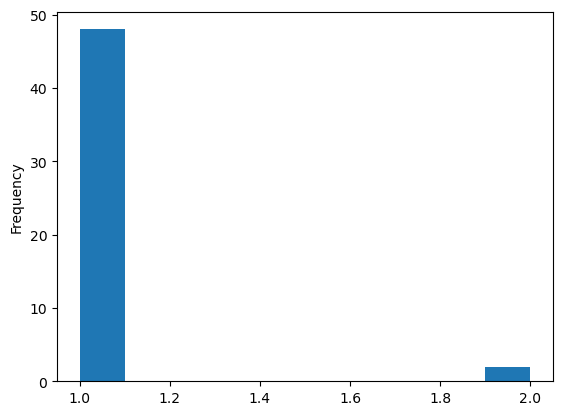

In [138]:
df_feature['Centroids'].iloc[:50].apply(len).plot(kind='hist')

In [140]:
df_feature['Centroids'].apply(len).plot(kind='hist')

,Frame,Centroids,Area
0,1,"[[161, 322]]",[571.0]
1,2,"[[161, 322]]",[579.5]
2,3,"[[163, 321]]",[385.0]
3,4,"[[161, 323]]",[580.0]
4,5,"[[159, 323]]",[685.5]
...,...,...,...
95,96,"[[194, 336], [203, 325], [177, 269], [171, 292...","[8.5, 6.5, 7.0, 4849.0, 664.0, 461.0]"
96,97,"[[247, 270], [169, 292]]","[351.5, 7584.0]"
97,98,"[[216, 380], [245, 266], [167, 294], [302, 207]]","[176.5, 534.0, 11725.0, 183.5]"
98,99,"[[209, 389], [219, 389], [247, 268], [158, 297...","[30.5, 42.5, 416.0, 12530.5, 614.5]"


<Axes: >

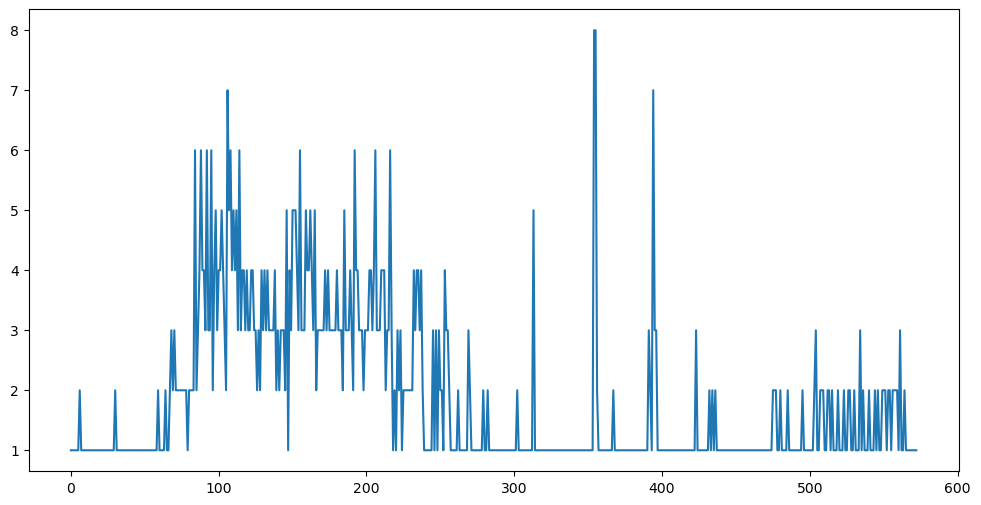

In [144]:
plt.figure(figsize=(12,6))
df_feature['Centroids'].apply(len).plot()

In [160]:
np.array(Countour_list).shape
            

ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (573,) + inhomogeneous part.

In [148]:
np.linalg.norm()

TypeError: unsupported operand type(s) for -: 'list' and 'list'

In [149]:
from itertools import product
from scipy.spatial import distance


In [153]:
list1 = [(1, 2), (3, 4), (5, 6)]
list2 = [(7, 8), (9, 10), (11, 12), (10,10)]

# Find all unique combinations of coordinates between the two lists
combinations = list(product(list1, list2))

In [154]:
combinations

[((1, 2), (7, 8)),
 ((1, 2), (9, 10)),
 ((1, 2), (11, 12)),
 ((1, 2), (10, 10)),
 ((3, 4), (7, 8)),
 ((3, 4), (9, 10)),
 ((3, 4), (11, 12)),
 ((3, 4), (10, 10)),
 ((5, 6), (7, 8)),
 ((5, 6), (9, 10)),
 ((5, 6), (11, 12)),
 ((5, 6), (10, 10))]

In [157]:
p = 52/65
r = 52/59
print(2*(p*r)/(p+r))

0.8387096774193548


In [167]:
src_pt = [161, 322]
value_list =[]
for i in range(len(df_feature)):
    centroids = df_feature['Centroids'].iloc[i]
    Area = df_feature['Area'].iloc[i]
    dist_list = []
    for dest_pt in centroids:
        dist_list.append(distance.euclidean(src_pt,dest_pt))
    value_list.append(Area[np.argmin(dist_list)])

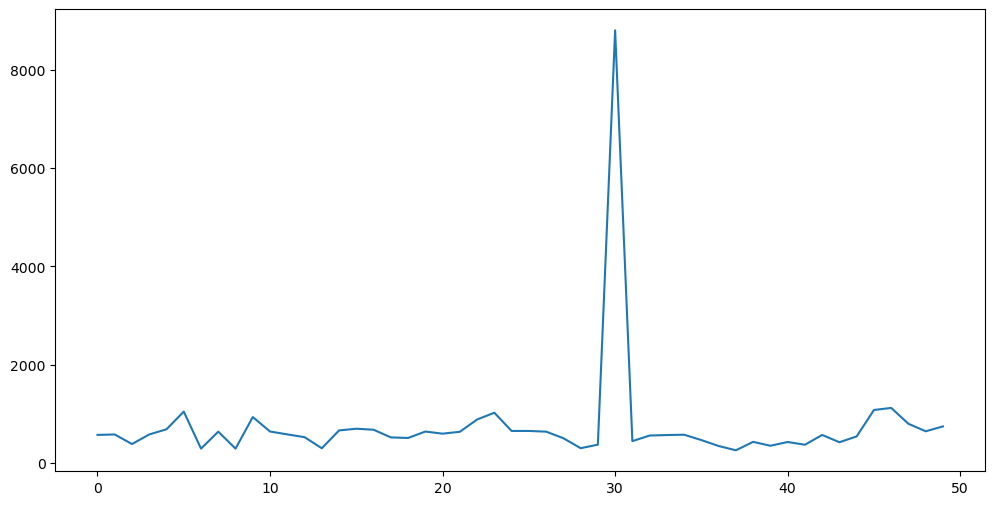

In [170]:
plt.figure(figsize=(12,6))
plt.plot(value_list[:50])